In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
data_list_img = pd.read_csv("../../Results/AE_tif_mixed_bright/image_list.csv", index_col=0)
data_AE = pd.read_csv("../../Results/AE_tif_mixed_bright/metrics_AE.csv", index_col=0)

In [3]:
PREDICTION_ITERATION=1
data = data_AE.merge(data_list_img, on="Image_path")
data = data[data["prediction_interation"]==PREDICTION_ITERATION]
data.columns

Index(['normalization', 'standardization', 'image_type', 'channel_image',
       'image_resize_x', 'image_resize_y', 'Image_path', 'autoencoder_name',
       'prediction_interation', 'prediction_size', 'gini_pxl_space',
       'kurtois_pxl_space', 'entropy_pxl_space', 'gini_latent_space',
       'kurtois_latent_space', 'entropy_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start',
       'latent_distance_to_start', 'SSIM_compared_to_start',
       'MSE_compared_to_previous_step', 'latent_distance_to_previous_step',
       'SSIM_compared_to_previous_step', 'filename', 'type', 'folder',
       'habitat', 'color_control', 'tv_loss', 'layers', 'sex', 'fish_n',
       'species', 'img_width', 'img_height', 'image_extension'],
      dtype='object')

In [4]:
data.head(3)

,normalization,standardization,image_type,channel_image,image_resize_x,image_resize_y,Image_path,autoencoder_name,prediction_interation,prediction_size,...,habitat,color_control,tv_loss,layers,sex,fish_n,species,img_width,img_height,image_extension
1,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Bedrock240_LD6_pred...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg
51,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Boulder240_LD6_pred...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg
101,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Detritus240_LD6_pre...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg


In [5]:
n_m = data[data["sex"]=="M"]['Image_path'].nunique()
print(n_m)
n_f = data[data["sex"]=="F"]['Image_path'].nunique()
print(n_f)
data["sex"].value_counts()
print(5*(n_f+n_m))
data[data["sex"]=="0"]['Image_path'].unique()
#data[data["sex"]=="0"]="M"

216
191
2035


array(['/home/durrmeyer/Images/Poissons/JPEG Cropped/gracile/GRAC_BRCK_M02_0.jpg',
       '/home/durrmeyer/Images/Poissons/JPEG Cropped/gracile/GRAC_BRCK_M01_0.jpg'],
      dtype=object)

Normalize the values per network and per sex

In [6]:
columns_values = [
                  "gini_latent_space", "kurtois_latent_space", "mean_activation_latent_space", 
                #"entropy_latent_space", "SSIM_compared_to_start",
                  "MSE_compared_to_start",
                 ]

In [7]:
norm_data  = data
norm_data[columns_values] = data.groupby(['sex','autoencoder_name'])[columns_values].transform(lambda x: (x - x.mean()) / x.std())

In [8]:
norm_data.head(3)

,normalization,standardization,image_type,channel_image,image_resize_x,image_resize_y,Image_path,autoencoder_name,prediction_interation,prediction_size,...,habitat,color_control,tv_loss,layers,sex,fish_n,species,img_width,img_height,image_extension
1,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Bedrock240_LD6_pred...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg
51,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Boulder240_LD6_pred...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg
101,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/p...,ConvolutionnalModelTrained_Detritus240_LD6_pre...,1.0,128.0,...,not_listed,NaN,NaN,NaN,F,2.0,punctulatum,6543,2213,.jpg


In [9]:
norm_data.columns

Index(['normalization', 'standardization', 'image_type', 'channel_image',
       'image_resize_x', 'image_resize_y', 'Image_path', 'autoencoder_name',
       'prediction_interation', 'prediction_size', 'gini_pxl_space',
       'kurtois_pxl_space', 'entropy_pxl_space', 'gini_latent_space',
       'kurtois_latent_space', 'entropy_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start',
       'latent_distance_to_start', 'SSIM_compared_to_start',
       'MSE_compared_to_previous_step', 'latent_distance_to_previous_step',
       'SSIM_compared_to_previous_step', 'filename', 'type', 'folder',
       'habitat', 'color_control', 'tv_loss', 'layers', 'sex', 'fish_n',
       'species', 'img_width', 'img_height', 'image_extension'],
      dtype='object')

ADD the columns 1 if from the same habitat else 0 

In [10]:
def isSameHabitat(serie):
    if serie["habitat"] in serie["autoencoder_name"].lower():
        return pd.Series([1], index=["same_env"])
    else:
        return pd.Series([0], index=["same_env"])

col_var_explicative = norm_data[["habitat", "autoencoder_name"]].apply(isSameHabitat, axis=1)
counts = col_var_explicative.value_counts()
print(np.array(counts)[0]+np.array(counts)[1])
counts

2045


same_env
0           1652
1            393
dtype: int64

Calculate the accuray if the prediction is always 0

In [11]:
counts = np.array(counts)
pred0 = counts[0]+counts[1]
tot = counts[0]+counts[1]

TP= 0
TN= counts[0]
FP= 0
FN= counts[1]
print(TP, TN, FP, FN)
bad_acc = (TP + TN)/(TP + TN + FP + FN)
print(bad_acc)

0 1652 0 393
0.8078239608801956


If I only predict 0s I'll have an accuracy of 

In [12]:
ext_data = pd.concat([norm_data, col_var_explicative], axis=1)

In [13]:
columns_needed = ["Image_path", "autoencoder_name", "habitat", "same_env", *columns_values]

data_male = ext_data[ext_data["sex"]=="M"][columns_needed]
data_female = ext_data[ext_data["sex"]=="F"][columns_needed]

In [14]:
data_male.columns

Index(['Image_path', 'autoencoder_name', 'habitat', 'same_env',
       'gini_latent_space', 'kurtois_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start'],
      dtype='object')

<AxesSubplot:>

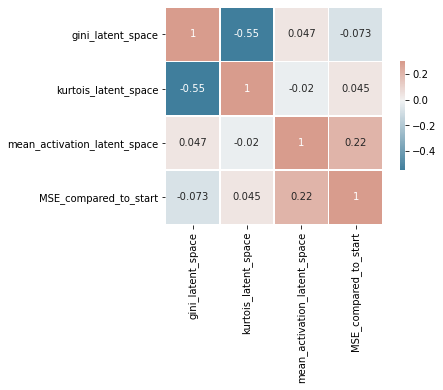

In [15]:
corr_male = data_male[columns_values].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_male, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

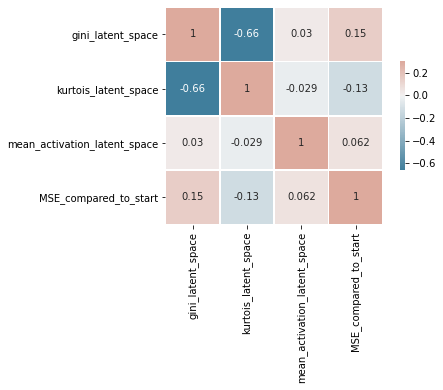

In [16]:
corr_female = data_female[columns_values].corr()

sns.heatmap(corr_female, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [17]:
from sklearn.linear_model import LogisticRegression

# GINI LATENT

In [18]:
def regression(data, variable, title=""):
    X = data[variable].to_numpy().reshape(-1, 1)
    y = data["same_env"]
    reg = LogisticRegression().fit(X, y)
    print("accuracy score of the logistic regression: {} , bad accuracy at {}".format(
        round(reg.score(X, y), 4), round(bad_acc, 4)))
    sns.histplot(data=data, x=variable, hue="same_env", kde=True, stat="probability", common_norm=False).set_title(title)
    plt.show()

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078


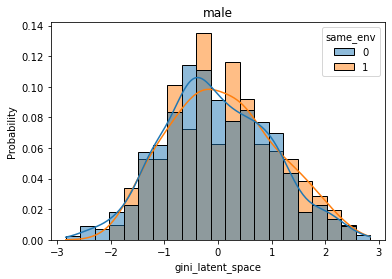

accuracy score of the logistic regression: 0.8073 , bad accuracy at 0.8078


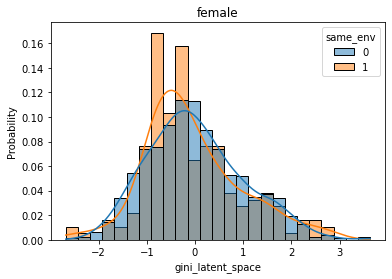

In [19]:
regression(data_male, "gini_latent_space", title="male")
regression(data_female, "gini_latent_space", title="female")

# Kurtosis Latent

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078


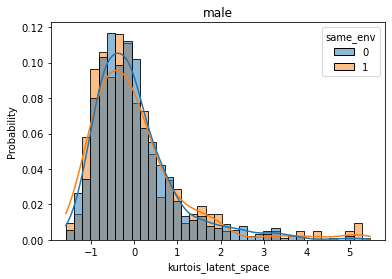

accuracy score of the logistic regression: 0.8073 , bad accuracy at 0.8078


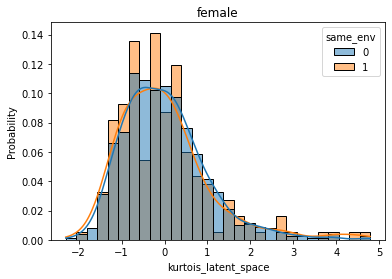

In [20]:
regression(data_male, "kurtois_latent_space", title="male")
regression(data_female, "kurtois_latent_space", title="female")

# Difference MSE

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078


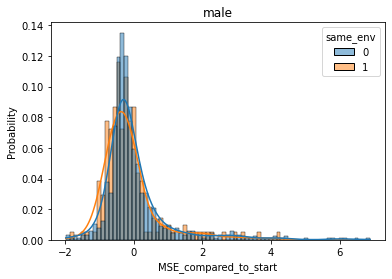

accuracy score of the logistic regression: 0.8073 , bad accuracy at 0.8078


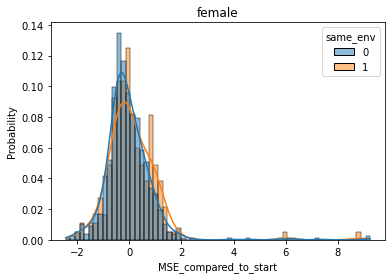

In [21]:
regression(data_male, "MSE_compared_to_start", title="male")
regression(data_female, "MSE_compared_to_start", title="female")

# Mean Latent

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078


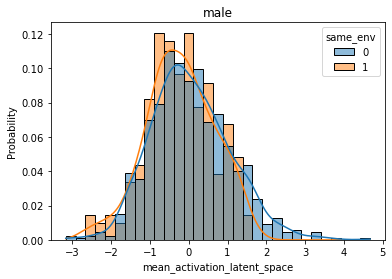

accuracy score of the logistic regression: 0.8084 , bad accuracy at 0.8078


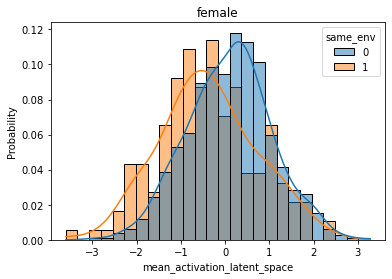

In [22]:
regression(data_male, "mean_activation_latent_space", title="male")
regression(data_female, "mean_activation_latent_space", title="female")

# Visualization of multiple params

In [23]:
%matplotlib qt
def do_multi_reg(data, params):
    X = data[params]
    y = data["same_env"]
    reg = LogisticRegression().fit(X, y)
    print("accuracy score of the logistic regression: {} , bad accuracy at {}".format(
        round(reg.score(X, y), 4), round(bad_acc, 4)))

def plot_multi_regression(data, params, title=""):
    # generate data    
    n = 200
    x = data[params[0]]
    y = data[params[1]]
    z = data[params[2]]

    # axes instance
    fig = plt.figure(figsize=(6,6))
    fig.suptitle(title)
    ax = Axes3D(fig)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("tab10", 256).as_hex())
    # plot
    sc = ax.scatter(x, y, z, s=40, c=data["same_env"], marker='o', cmap=cmap, alpha=0.8)
    ax.set_xlabel(params[0])
    ax.set_ylabel(params[1])
    ax.set_zlabel(params[2])

    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()
    #regression
    do_multi_reg(data, params)

In [24]:
grp = ["mean_activation_latent_space", "MSE_compared_to_start", "kurtois_latent_space"]
plot_multi_regression(data_male, grp, "male")
plot_multi_regression(data_female, grp, "female")

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078
accuracy score of the logistic regression: 0.8052 , bad accuracy at 0.8078


In [25]:
grp = ["mean_activation_latent_space", "MSE_compared_to_start", "gini_latent_space"]
plot_multi_regression(data_male, grp, "male")
plot_multi_regression(data_female, grp, "female")

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078
accuracy score of the logistic regression: 0.8052 , bad accuracy at 0.8078


# TOTAL LOGISTIC REGRESSION

In [26]:
do_multi_reg(data_male, columns_values)

accuracy score of the logistic regression: 0.8083 , bad accuracy at 0.8078
